Cybersecurity is of paramount importance in the modern world for any government and any enterprise. Governments and Enterprises are under constant cyber attacks from all kinds of adversaries. It is said that the next war will be fought in the Cyber Space. So, it is of utmost importance to develop products and strategies to be able to deal with the threat of cyber attacks.

One of the means of cyber-attacks is through malwares. Malwares are malicious computer programs embedded in the software of regular use. For example, an email may carry a malware that can infect the machine of the receiver of the email and then spread across an enterprise.

One very ubiquitous file exchanged by people across the globe are images. The advent of social media has boosted the exchange of images. Images can be exchanged not only between two computers; but also using devices like mobile phone, etc. Also, it is the tendency of people to spread images across wide circles. So, developers of malware target embedding their malicious code into images so that it gets a lot of traction.

One of the very popular forms of image files is JPEG files. So, infecting JPEG files has lots of incentives for malware developers. So far, anitivirus software has been developed which studies signatures inside the JPEG files to detect presence of malware. However, this technique is expensive as large teams have to be deployed to constantly research for new signatures. **This notebook aims to use supervised machine learning so that computers can detect the malware in JPEG files without having to constantly feed the computer with knowledge of new signatures.**

## About JPEG Files

JPEG Files are compressed files used to store images. The JPEG Files can be identified by a marker 0xFFD8 at the start of the file.

The information in the JPEG Files can be classified into 2 types - Image Data and EXIF Tags. EXIF Tags were added to JPEG file format in 2010.

### The Image Data of JPEG files have the following segments:
1. Header
2. 2 Quantization Tables
3. Frame Information

The **Header** segment contains the following data:
1. Identifier (OxJFIF for JPEG, etc)
2. Version
3. Units
4. Density
5. Thumbnail

The **Quantization Table 1** contains the data regarding the luminance of the image. It is an 8 * 8 table.
The **Quantization Table 2** contains the data regarding the chrominance of the image. It is an 8 * 8 table.

The **Frame Information** is a series of Huffman-encoded tables containing the bit pattern of the image.

*The important thing to note is that if any of the above values is tampered with, the JPEG file will not render appropriately.* So, the developers of Malware do not tamper with this part of JPEG files to introduce malware.

### EXIF Tags
Exif Tags provide additional information to the JPEG Files. The EXIF Tags can be altered programmatically to alter the nature of the image stored in the JPEG files. For example, by altering the Exif Tag BrightnessValue, the brightness of the image can be altered. Similarly, by altering the Exif Tags ExifImageHeight and ExifImageWidth, the size of the image can be altered.

Exif Tags provide the facility for photograph editors to make enhancements/alterations to an image stored as a JPEG File. *As these are values that can be altered, the developers of Malware alter these tags to introduce their spurious code.* **One way to clean an infected JPEG file is to convert the JPEG File to a BMP File. BMP Files can only contain image information and do not support any Exif tags. Converting to BMP files gets rid of the Exif tags and thus the JPEG files get cleaned of malware.**

A JPEG File may contain Exif Tags or may not contain Exif Tags. Definitely, JPEG Files created before 2010 do not contain Exif Tags.

### Conclusion
If a JPEG File does not contain Exif tags, then it can be safe to state that the JPEG File can be considered a clean file.

So, **for malware analysis, we need to concentrating only on JPEG Files that contain Exif Tags.**

## Building and Testing the model

The document states all the programming steps taken to build and test the model.

### Constants
Constants were used to avoid hard coding. This also gave the advantage that indicators could be changed in one place to impact the complete program.

In [1]:
# Constants
FILE_NAME_COLUMN_NAME = 'FileName'
FILE_TYPE_COLUMN_NAME = 'FileType'
TAG_STRING_COLUMN_NAME = 'TagString'
NUMERIC_COLUMN_IDENTIFIER = 'AAA'
BENIGN_FILE = 0
FILE_WITH_MALWARE = 1

### Functions used to extract EXIF Tags from JPEG Files
The following three functions were used to extract the EXIF Tags from the JPEG Files.

#### extractTagsFromADirectory
This function takes a single file name or a set of file names and returns the Tags extracted from all the JPEG Files as a List. Along with the Tags found in the set of JPEG Files, this function returns the number of valid JPEG Files, the number of invalid JPEG files and the number of JPEG Files that contained no tags.

This function calls the functions JPEGFileFeatureExtractorToDictionary() and isImageFile().

#### JPEGFileFeatureExtractorToDictionary
This function takes one JPEG file as input and returns all the EXIF Tags in the JPEG file in a Dictionary as output.

#### isImageFile
This function takes a file as input and returns TRUE if the file is a JPEG File and returns FALSE if the file is not a JPEG File.

In [2]:
import glob

def extractTagsFromADirectory(inputDirectory):
    # Declare Counters
    numberOfValidFiles = 0
    numberOfInvalidFiles = 0
    numberOfFilesWithoutTags = 0

    # Create an Empty List to hold all the features of all the files
    returnValue = []
    
    n = 0
    
    # Loop through all the files in the Input Directory
    for file in glob.glob(inputDirectory):
        # Create an empty Dictionary
        oneFileFeatures = {}
        
        try:
            # Read the file and extract the features
            fileFeatures = JPEGFileFeatureExtractorToDictionary(file)

            # If the File had some features, then create an entry for the file
            if len(fileFeatures.keys()) > 0:
                # Write the File Name
                oneFileFeatures[FILE_NAME_COLUMN_NAME] = file

                # Add the File Features to the main Dictionary
                oneFileFeatures.update(fileFeatures)
            
                # Add the entry to the return value
                returnValue.append(oneFileFeatures)
                
                numberOfValidFiles = numberOfValidFiles + 1
            else:
                # Check if the file is a valid Image File
                if isImageFile(file):
                    numberOfFilesWithoutTags = numberOfFilesWithoutTags + 1
                else:
                    numberOfInvalidFiles = numberOfInvalidFiles + 1
 
        except:
            # Check if the file is a valid Image File
            if isImageFile(file):
                numberOfFilesWithoutTags = numberOfFilesWithoutTags + 1
            else:
                numberOfInvalidFiles = numberOfInvalidFiles + 1
            
    return (returnValue, numberOfValidFiles, numberOfInvalidFiles, numberOfFilesWithoutTags)

In [3]:
from PIL import Image
from PIL.ExifTags import TAGS

def JPEGFileFeatureExtractorToDictionary(imageFile):
    #Declare an empty Dictionary
    returnValue = {}
    
    # read the image data using PIL
    image = Image.open(imageFile)
    
    # extract EXIF data
    exifdata = image.getexif()

    # iterating over all EXIF data fields
    for tag_id in exifdata:
        # get the tag name
        tag = TAGS.get(tag_id, tag_id)
        data = exifdata.get(tag_id)
        # decode bytes 
        if isinstance(data, bytes):
            data = data.decode('iso8859-1')

        returnValue[tag] = data
        
    return returnValue

In [4]:
from PIL import Image

def isImageFile(imageFileName):
    returnValue = True
    
    try:
        img = Image.open('./' + imageFileName) # open the image file
        img.verify() # verify that it is an image
    except (IOError, SyntaxError) as e:
        returnValue = False
        
    return returnValue

### Extracting Features from Benign Files

In this step, the program extracts all the features from the clean JPEG Files. All the clean JPEG files were stored in a separate directory for easy classification.

In [5]:
benignFileFeatures, numValidFiles, numInvalidFiles, numFilesWithoutTags = extractTagsFromADirectory("./Data/clean_jpeg/*.j*")
print("Valid JPEG Files = %d\nInvalid Image Files = %d\nJPEG Files without Tags = %d" % (numValidFiles, numInvalidFiles, numFilesWithoutTags))

Valid JPEG Files = 4582
Invalid Image Files = 0
JPEG Files without Tags = 816


### Extracting Features from File containing Malware
In this step, the program extracts the features from the JPEG files containing malware.

In [6]:
malwareFileFeatures, numValidFiles, numInvalidFiles, numFilesWithoutTags = extractTagsFromADirectory("./Data/malicious_files/*")
print("Valid JPEG Files = %d\nInvalid Image Files = %d\nJPEG Files without Tags = %d" % (numValidFiles, numInvalidFiles, numFilesWithoutTags))

Valid JPEG Files = 400
Invalid Image Files = 12
JPEG Files without Tags = 3


### Creating a Data Frame containing all the Keys extracted in the previous step

#### fillDataInDataFrame
Function to create a data frame of all the tags available in the set of JPEG Files.

In [7]:
import pandas as pd
from tqdm import tqdm

def fillDataInDataFrame(featureDictionary, extractionDescription, fileType):
    # Create an Empty DataFrame object
    df = pd.DataFrame()

    for record in tqdm(featureDictionary, desc = extractionDescription):
        # Create an empty Dictionary
        oneRecord = {}

        # Create an empty string
        recordString = ""

        # Loop through all the features in a record
        for k in record.keys():
            # Extract the value for the key and append to the record string
            # This will be used for TFID
            # Add a SPACE between each tag value
            # Do not include File Name
            if k != FILE_NAME_COLUMN_NAME:
                recordString = recordString + str(record[k]) + " "

        # Add the record string as a separate column in the record
        oneRecord[TAG_STRING_COLUMN_NAME] = recordString[:-1]

        # Add column to mark Dependent Column as Benign File
        oneRecord[FILE_TYPE_COLUMN_NAME] = pd.to_numeric(fileType, downcast = 'integer')

        # Add the Record to the Data Frame
        df = pd.concat([df, 
                        pd.DataFrame(oneRecord, 
                                     columns = [TAG_STRING_COLUMN_NAME, FILE_TYPE_COLUMN_NAME],
                                     index = [0])])

    return df

### Creating data frames of tags
In this step, 2 data frames are created - one containing the tags from clean JPEG Files and one containing tags from JPEG Files containing malware.

In [8]:
benignFileDF = fillDataInDataFrame(benignFileFeatures, 'Extracting Clean Files Features', BENIGN_FILE)
malignantFileDF = fillDataInDataFrame(malwareFileFeatures, 'Extracting Features from Files with Malware', FILE_WITH_MALWARE)

Extracting Features from Files with Malware: 100%|██████████| 400/400 [00:00<00:00, 1612.52it/s]


### Creating a single data frame containing all the tags
In this step, the 2 data frames created in the previous step are concatenated into a single data frame.

In [9]:
df = pd.concat([benignFileDF, malignantFileDF], ignore_index = True)
df['FileType'] = pd.to_numeric(df['FileType'], downcast='integer')

In the next step, the CHR(0) is eliminated from the tags.

So far, we have extracted the features from the JPEG Files. Features were extracted from JPEG Files containing malware and clean JPEG Files. Now, these features need to be organized so that models can be prepared for classifying JPEG Files as Clean or JPEG Files Containing Malware.

**Notice that we have 4,582 clean JPEG Files and 400 JPEG Files with Malware in our data frame.**

In [10]:
df[FILE_TYPE_COLUMN_NAME].value_counts()

0    4582
1     400
Name: FileType, dtype: int64

In [11]:
dfTFID = df[[TAG_STRING_COLUMN_NAME, FILE_TYPE_COLUMN_NAME]].copy()

In [12]:
dfTFIDClean = pd.DataFrame()
for i in dfTFID.index:
    dfTFIDClean.loc[i, TAG_STRING_COLUMN_NAME] = dfTFID.iloc[i, 0].replace(chr(0), '')
    dfTFIDClean.loc[i, FILE_TYPE_COLUMN_NAME] = dfTFID.iloc[i, 1]

In [13]:
dfTFIDClean.shape

(4982, 2)

### Forming the TF-IDF
TF-IDF is the acronym for **Term Frequency-Inverse Document Frequency**. TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. In this case, each JPEG file is a document in the collection and each tag or part of a tag in each JPEG File is a Term.

The TF-IDF is stored in an array with each element of the array corresponding to a JPEG file in the same order as we formed the data frame. This forms the set of independent variables for our Machine Learning model. The independent variables are stored in variable **X**. The dependent variable is the set of FILE-TYPE as recorded while loading the JPEG Files *(Remember that the clean JPEG files were stored in a separate directory and all these files were read as a set and marked as benign. Similarly, all the JPEG files with malware were stored in a separate directory and read as a set and marked as MALWARE).*

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(max_features = 90000, ngram_range = (1,4))
X = tfidfconverter.fit_transform(dfTFIDClean.TagString).toarray()

In [15]:
y = dfTFID.FileType
y.value_counts()

0    4582
1     400
Name: FileType, dtype: int64

In [16]:
X.shape

(4982, 39747)

### Principal Component Analysis (PCA)
After forming the TF-IDF, we see that we have nearly 40,000 features. This is a lot of features. From among so many features, not many will contribute to the model. So, we need to reduce the number of features to a smaller number and only retain the features which will meaningfully contribute to the model.

To do so, we use PCA. First, we will run the PCA function as it is and determine how many features are contributing maximum to the model. Then, we will transform our input data to only retain the most important features.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42)
XTrail = pca.fit_transform(X)
print(XTrail.shape)

(4982, 4982)


<AxesSubplot:title={'center':'Variability Explained by Principal Components'}>

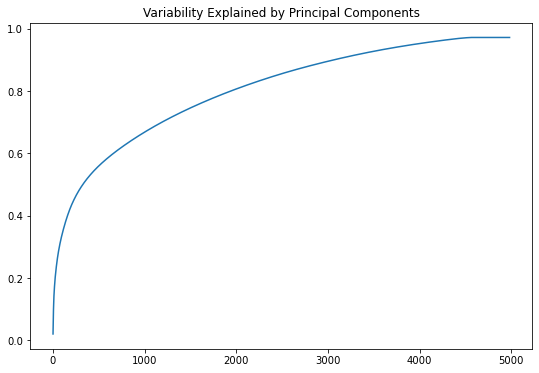

In [18]:
pcaPlot = pd.Series(data = pca.explained_variance_.cumsum())
pcaPlot.plot(title = 'Variability Explained by Principal Components', 
             figsize = (9,6), legend = False)

We see that about 4,800 variables explain about 95% of the variability in the data. So, we will retain only 4,800 features as determined by PCA.

In [19]:
pca = PCA(n_components = 4800, random_state = 42)
X = pca.fit_transform(X)
print(X.shape)

(4982, 4800)


### Handling the Imbalanced Data Sets
Notice that we have 4,582 clean JPEG Files and 400 JPEG Files with malware. So, our data set is imbalanced as we have more than 10 times the number of clean JPEG files as compared to the number of JPEG files with malware. Imbalanced data sets will cause algorithms like Decision Tree (and most other algorithms) to not be able function properly.

To resolve the problem of the imbalanced data set, we over-sample the data set. Oversampling means that we try to increase the number of data points in the class which has less number of data points to have a similar number of data points as the other set with more data points. For oversampling, we will use **SMOTE (Synthetic Minority Over-sampling Technique)** algorithm.

Notice that after applying SMOTE, we have 9,164 data points in our data set and there are 4,582 data points for clean JPEG Files and 4,582 data points for JPEG Files with malware.

In [20]:
# For SMOTE
import imblearn as ib

# Transform the dataset
oversample = ib.over_sampling.SMOTE(random_state = 42)
X, y = oversample.fit_resample(X, y)

In [21]:
X.shape

(9164, 4800)

In [22]:
y.value_counts()

0    4582
1    4582
Name: FileType, dtype: int64

### Forming the Decision Tree Model
Now that we have the data in the form we desire, we form the Model using the Decision Tree algorithm.

In [23]:
from sklearn.tree import DecisionTreeClassifier

modelDT = DecisionTreeClassifier(random_state = 42)
modelDT.fit(X, y)

DecisionTreeClassifier(random_state=42)

**Now that the model is ready, we evaluate the model on the Training Data.**



Confusion Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4582
           1       1.00      1.00      1.00      4582

    accuracy                           1.00      9164
   macro avg       1.00      1.00      1.00      9164
weighted avg       1.00      1.00      1.00      9164



Accuracy: 99.96726%


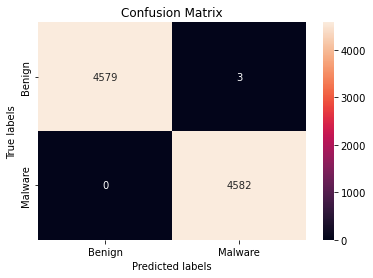

In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt     
import seaborn as sns

y_pred = modelDT.predict(X)

cm = metrics.confusion_matrix(y, y_pred)

ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Malware']); 
ax.yaxis.set_ticklabels(['Benign', 'Malware']);

print("\n\nConfusion Classification Report\n")
print(metrics.classification_report(y, y_pred))

print("\n\nAccuracy: %5.5f%s" % (metrics.accuracy_score(y, y_pred) * 100, "%"))

### Making predictions for test data
Now that the models are ready, we test the models using the test data.

First the Decision Tree Model is tested.

To test the models with the test data, we need to conduct the following steps:
1. Read the Tags from the clean JPEG Files and form the data frame of tags and mark these rows as Benign files.
2. Read the Tags from the JPEG Files containing malware and form the data frame of tags and mark these rows as JPEG files containing malware.
3. Combine the two dataframes created in steps 1 and 2 into a single data frame (We could have tested the two data frames created in steps 1 and 2 separately as well).
4. Remove the CHR(0) from the tags.
5. Then we form the TF-IDF using the TF-IDF converter already created before (It is important to note that we should use the same TF-IDF converter as the number of features in the TF-IDF should be the same as that was used to create the models).
6. Once the TF-IDF is ready, we apply Principle Component Analysis to reduce the number of features.
7. Once all of the above is over, we can use the model to make the predictions.


BENIGN FILES
------------
Valid JPEG Files = 117
Invalid Image Files = 0
JPEG Files without Tags = 175


Extracting Clean Files Features for Test Data: 100%|██████████| 117/117 [00:00<00:00, 1658.06it/s]



MALWARE FILES
-------------
Valid JPEG Files = 22
Invalid Image Files = 0
JPEG Files without Tags = 0


Extracting Clean Files Features for Test Data: 100%|██████████| 22/22 [00:00<00:00, 1751.74it/s]

0    117
1     22
Name: FileType, dtype: int64




Confusion Classification Report

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       117
           1       0.68      0.95      0.79        22

    accuracy                           0.92       139
   macro avg       0.83      0.93      0.87       139
weighted avg       0.94      0.92      0.93       139



Accuracy: 92.08633%


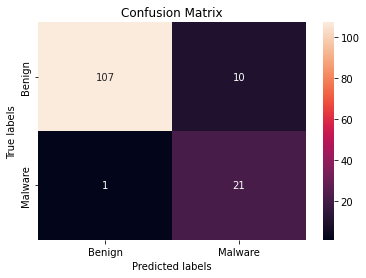

In [25]:
# Read the data for the Benign Files
testCleanFeatures, numValidFiles, numInvalidFiles, numFilesWithoutTags = extractTagsFromADirectory("./Data/ValidationSet-Clean/*.j*")
print("\nBENIGN FILES\n------------\nValid JPEG Files = %d\nInvalid Image Files = %d\nJPEG Files without Tags = %d" % (numValidFiles, numInvalidFiles, numFilesWithoutTags))

# Form the data frame
testCleanDF = fillDataInDataFrame(testCleanFeatures, 'Extracting Clean Files Features for Test Data', BENIGN_FILE)

# Read the data for the file with Malware
testMalwareFeatures, numValidFiles, numInvalidFiles, numFilesWithoutTags = extractTagsFromADirectory("./Data/ValidationSet-Malicious/*")
print("\nMALWARE FILES\n-------------\nValid JPEG Files = %d\nInvalid Image Files = %d\nJPEG Files without Tags = %d" % (numValidFiles, numInvalidFiles, numFilesWithoutTags))

# Form the data frame
testMalwareDF = fillDataInDataFrame(testMalwareFeatures, 'Extracting Clean Files Features for Test Data', FILE_WITH_MALWARE)

# Combine the 2 data frames formed above
testDF = pd.concat([testCleanDF, testMalwareDF], ignore_index=True)
testDF['FileType'] = pd.to_numeric(testDF['FileType'], downcast = 'integer')

# Create data for TFID
testTFIDDF = testDF[[TAG_STRING_COLUMN_NAME, FILE_TYPE_COLUMN_NAME]].copy()

# Clean the data
testTFIDClean = pd.DataFrame()
for i in testTFIDDF.index:
    testTFIDClean.loc[i, TAG_STRING_COLUMN_NAME] = testTFIDDF.iloc[i, 0].replace(chr(0), '')
    testTFIDClean.loc[i, FILE_TYPE_COLUMN_NAME] = testTFIDDF.iloc[i, 1]
    
# Drop NULL Values
testTFIDClean = testTFIDClean.dropna()
testTFIDClean[FILE_TYPE_COLUMN_NAME]= pd.to_numeric(testTFIDClean[FILE_TYPE_COLUMN_NAME], downcast='integer')
print(testTFIDClean[FILE_TYPE_COLUMN_NAME].value_counts())

# Create the TFID
X = tfidfconverter.transform(testTFIDClean.TagString).toarray()
y = testTFIDClean.FileType

# Apply PCA
X = pca.transform(X)

# Make the prediction as per the Decision Tree Model and check the result
y_pred = modelDT.predict(X)

cm = metrics.confusion_matrix(y, y_pred)

ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Malware']); 
ax.yaxis.set_ticklabels(['Benign', 'Malware']);

print("\n\nConfusion Classification Report\n")
print(metrics.classification_report(y, y_pred))

print("\n\nAccuracy: %5.5f%s" % (metrics.accuracy_score(y, y_pred) * 100, "%"))